In [1]:
# Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Center For Community Service
#### Project: Data Analysis on E-bike Survey Collected on 04/29/2023

## Part I: Data Cleaning

In [2]:
# Read survey data from the csv file
df = pd.read_csv("4.29.2023_Survey_Results.csv")
df.head()

,Timestamp,Who took this survey (initials),Are you a bike rider?,What is your zip code?,Do you or anyone in your family ride an e-bike?,"How do you commute - to work, school, or for other purposes?",How far (ROUND TRIP) do you commute for any purpose each day?,Would you commute by e-bike if given the opportunity?,"Do you know the differences between Class 1, Class 1, and Class 3 e-bikes?",How comfortable would you be storing your bike in a bike locker while you are commuting? -- secure private locker like this:,How comfortable would you be storing your bike in a bike locker while you are commuting? -- group locker like this:,How familiar are you and those in your family with the rules of the road for e-bikes?,How concerned are you about e-bikes and e-bike safety in San Diego County?,Are you interested in learning more about e-bikes?,Any additional comments?,Who's survey is this?,Unnamed: 16
0,"April 29, 2023",JTB,No,92115.0,No,I do not commute,NaN,Maybe,No,Very,Very,Don't know,Not very,No,NaN,carsonator0898@gmail.com,NaN
1,"April 29, 2023",JTB,No,92129.0,No,Car,No,No,A bit,NaN,NaN,Not very,somewhat,No,NaN,NaN,NaN
2,"April 29, 2023",JTB,No,92115.0,Dad,Public transportation,1 mile,Maybe,A bit,Very,somewhat,Don't know,Very,Yes,NaN,risela.delosangles@gmail.com,NaN
3,"April 29, 2023",JTB,No,92562.0,No,I do not commute,NaN,NaN,No,NaN,NaN,Don't know,Not concerned,May be,NaN,NaN,NaN
4,"April 29, 2023",JTB,Yes,92109.0,No,I do not commute,NaN,NaN,No,NaN,NaN,Don't know,Not concerned,No,NaN,NaN,NaN


In [3]:
df.shape

(65, 17)

In [4]:
# Keep numerical and binary columns
quant_df = df.drop("Who took this survey (initials)", axis=1)
quant_df.drop("Any additional comments?", axis=1, inplace=True)
quant_df.drop("Who's survey is this?", axis=1, inplace=True)
quant_df.drop("Timestamp", axis=1, inplace=True)
quant_df.drop("Unnamed: 16", axis=1, inplace=True)

# Change headers
quant_df.columns = ['bike_rider', 'zipcode', 'ebike_rider', 'commute_purpose',
                   'miles', 'try_bike', 'ebike_class', 'private_locker', 'group_locker',
                   'ebike_rules', 'safty', 'interested']

quant_df.head()

,bike_rider,zipcode,ebike_rider,commute_purpose,miles,try_bike,ebike_class,private_locker,group_locker,ebike_rules,safty,interested
0,No,92115.0,No,I do not commute,NaN,Maybe,No,Very,Very,Don't know,Not very,No
1,No,92129.0,No,Car,No,No,A bit,NaN,NaN,Not very,somewhat,No
2,No,92115.0,Dad,Public transportation,1 mile,Maybe,A bit,Very,somewhat,Don't know,Very,Yes
3,No,92562.0,No,I do not commute,NaN,NaN,No,NaN,NaN,Don't know,Not concerned,May be
4,Yes,92109.0,No,I do not commute,NaN,NaN,No,NaN,NaN,Don't know,Not concerned,No


In [5]:
quant_df.shape

(65, 12)

Here's a description of each feature (column) in the quant_df DataFrame:

Header | Description
-------|------------
bike_rider | Are you a bike rider?
zipcode | What is your zip code?
ebike_rider | Do you or anyone in your family ride an e-bike?
commute_purpose | How do you commute - to work, school, or for other purposes?
miles | How far (ROUND TRIP) do you commute for any purpose each day?
try_bike | Would you commute by e-bike if given the opportunity?
ebike_class | Do you know the differences between Class 1, Class 1, and Class 3 e-bikes?
private_locker | How comfortable would you be storing your bike in a private bike locker while you are commuting?
group_locker | How comfortable would you be storing your bike in a group bike locker while you are commuting?
ebike_rules | How familiar are you and those in your family with the rules of the road for e-bikes?
safty | How concerned are you about e-bikes and e-bike safety in San Diego County?
interested | Are you interested in learning more about e-bikes?


In [6]:
# convert all letters to lowercase
columns = quant_df.columns
for column in columns:
    if column != 'zipcode':
        quant_df[column] = quant_df[column].str.lower()


# remove unit in miles
quant_df.head()

,bike_rider,zipcode,ebike_rider,commute_purpose,miles,try_bike,ebike_class,private_locker,group_locker,ebike_rules,safty,interested
0,no,92115.0,no,i do not commute,NaN,maybe,no,very,very,don't know,not very,no
1,no,92129.0,no,car,no,no,a bit,NaN,NaN,not very,somewhat,no
2,no,92115.0,dad,public transportation,1 mile,maybe,a bit,very,somewhat,don't know,very,yes
3,no,92562.0,no,i do not commute,NaN,NaN,no,NaN,NaN,don't know,not concerned,may be
4,yes,92109.0,no,i do not commute,NaN,NaN,no,NaN,NaN,don't know,not concerned,no


In [7]:
# miles column cleaning - keep numbers only
quant_df['miles'] = quant_df['miles'].str.extract(r'(\d+)', expand=False).astype(float).astype(pd.Int64Dtype())
quant_df.head()

,bike_rider,zipcode,ebike_rider,commute_purpose,miles,try_bike,ebike_class,private_locker,group_locker,ebike_rules,safty,interested
0,no,92115.0,no,i do not commute,<NA>,maybe,no,very,very,don't know,not very,no
1,no,92129.0,no,car,<NA>,no,a bit,NaN,NaN,not very,somewhat,no
2,no,92115.0,dad,public transportation,1,maybe,a bit,very,somewhat,don't know,very,yes
3,no,92562.0,no,i do not commute,<NA>,NaN,no,NaN,NaN,don't know,not concerned,may be
4,yes,92109.0,no,i do not commute,<NA>,NaN,no,NaN,NaN,don't know,not concerned,no


## Part II: Analysis on Numerical and Categorical Features

#### Survey Question: Are you a bike rider? | Column: bike_rider

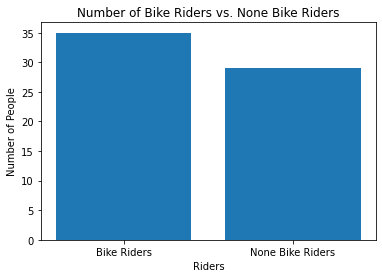

55% of the participants are bike riders
45% of the participants are NOT bike riders


In [8]:
# count number of bike rider and non-bike rider
bike_rider_count = quant_df['bike_rider'].value_counts()
bike_rider_yes = bike_rider_count[0] + bike_rider_count[2] + bike_rider_count[4]
bike_rider_no = bike_rider_count[1] + bike_rider_count[3]

# create bar plot
x = ['Bike Riders', 'None Bike Riders']
y = [bike_rider_yes, bike_rider_no]
plt.bar(x, y)

# add label to bar plot
plt.xlabel('Riders')
plt.ylabel('Number of People')
plt.title('Number of Bike Riders vs. None Bike Riders')

# display the plot
plt.show()

# show number of bike riders vs. none bike riders
bike_percent_yes = round(bike_rider_yes / (bike_rider_yes + bike_rider_no) * 100)
bike_percent_no = round(bike_rider_no / (bike_rider_no + bike_rider_yes) * 100)
print(f'{bike_percent_yes}% of the participants are bike riders')
print(f'{bike_percent_no}% of the participants are NOT bike riders')

#### Survey Question: What is your zip code? | Column: zipcode

In [9]:
# ENTER CODE HERE


#### Survey Question: Are you a ebike_rider? | Column: ebike_rider

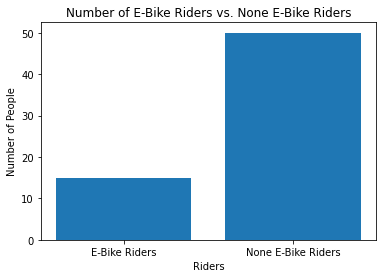

23% of the participants are e-bike riders
77% of the participants are NOT e-bike riders


In [10]:
# count number of ebike rider vs. non-ebike rider
ebike_rider_no = quant_df[quant_df['ebike_rider'] == 'no'].shape[0]
ebike_rider_yes = quant_df.shape[0] - ebike_rider_no

# create bar plot
x = ['E-Bike Riders', 'None E-Bike Riders']
y = [ebike_rider_yes, ebike_rider_no]
plt.bar(x, y)

# add label to bar plot
plt.xlabel('Riders')
plt.ylabel('Number of People')
plt.title('Number of E-Bike Riders vs. None E-Bike Riders')

# display the plot
plt.show()

# show number of bike riders vs. none bike riders
ebike_percent_yes = round(ebike_rider_yes / (ebike_rider_yes + ebike_rider_no) * 100)
ebike_percent_no = round(ebike_rider_no / (ebike_rider_no + ebike_rider_yes) * 100)
print(f'{ebike_percent_yes}% of the participants are e-bike riders')
print(f'{ebike_percent_no}% of the participants are NOT e-bike riders')

#### Survey Question: How do you commute - to work, school, or for other purposes? | Column: commute_purpose

#### Survey Question: How far (ROUND TRIP) do you commute for any purpose each day? | Column: miles

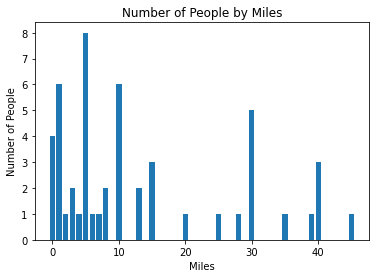

In [11]:
# count number of miles
miles_count = quant_df['miles'].value_counts()

# create bar plot
x = miles_count.index
y = miles_count.values
plt.bar(x, y)

# add label to bar plot
plt.xlabel('Miles')
plt.ylabel('Number of People')
plt.title('Number of People by Miles')

# display the plot
plt.show()

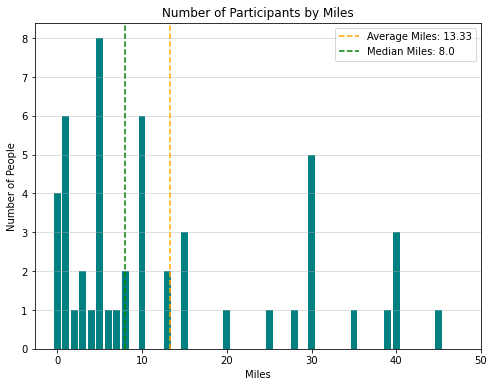

In [12]:
# count number of miles
mile_counts = quant_df['miles'].value_counts(sort = False)

# create bar plot
fig, ax = plt.subplots(figsize = (8, 6))
bars = ax.bar(mile_counts.index, mile_counts.values, color = 'teal')
ax.set_xlabel('Miles')
ax.set_ylabel('Number of People')
ax.set_title('Number of Participants by Miles')

# add a vertical line to show the average and median miles
ax.grid(axis = 'y', alpha = 0.5)
avg_miles = quant_df['miles'].mean()
med_miles = quant_df['miles'].median()
ax.axvline(x = avg_miles, color = 'orange', linestyle = '--', label = f'Average Miles: {avg_miles:.2f}')
ax.axvline(x = med_miles, color = 'green', linestyle = '--', label = f'Median Miles: {med_miles}')
ax.set_xticks(range(0, 51, 10))

# show the plot
ax.legend()
plt.show()

#### Survey Question: Would you commute by e-bike if given the opportunity? | Column: try_bike

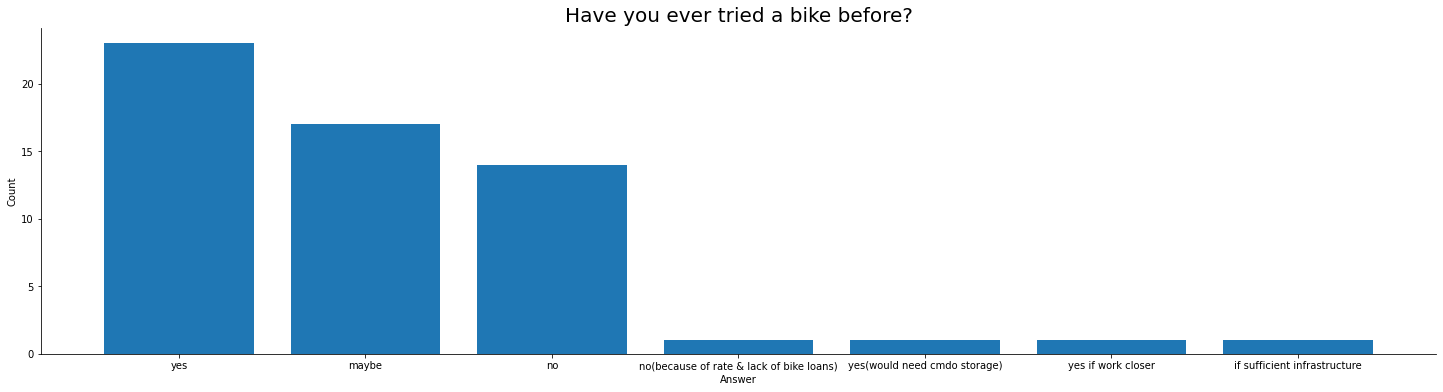

In [13]:
# Count the number of occurrences of each unique value in the try_bike column
try_bike_counts = quant_df['try_bike'].value_counts()

# Create a bar plot
f, ax = plt.subplots(figsize=(25, 6))
sns.despine(f)
plt.bar(try_bike_counts.index, try_bike_counts.values)

# Set the title and axis labels
plt.title('Have you ever tried a bike before?', fontsize = 20)
plt.xlabel('Answer')
plt.ylabel('Count')

# Show the plot
plt.show()

#### Survey Question: Do you know the differences between Class 1, Class 1, and Class 3 e-bikes? | Column: ebike_class

Text(0, 0.5, 'Count')

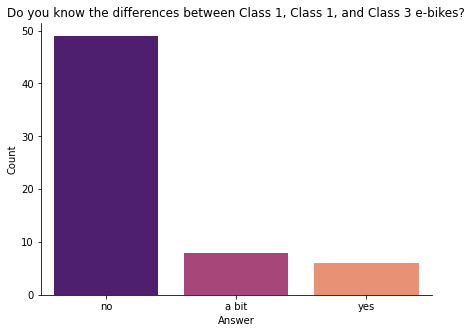

In [14]:
# Count the number of occurrences of each unique value in the ebike_class column
ebike_class_count = quant_df['ebike_class'].value_counts()

# Create a bar graph
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.barplot(x=ebike_class_count.index, y = ebike_class_count.values, palette='magma')

# Set title and labels to the graph
plt.title('Do you know the differences between Class 1, Class 1, and Class 3 e-bikes?')
plt.xlabel('Answer')
plt.ylabel('Count')


#### Survey Question: How comfortable would you be storing your bike in a private bike locker while you are commuting? | Column: private_locker

In [15]:
# ENTER CODE HERE
...

#### Survey Question: How comfortable would you be storing your bike in a group bike locker while you are commuting? | Column: group_locker

In [16]:
# ENTER CODE HERE
...

#### Survey Question: How familiar are you and those in your family with the rules of the road for e-bikes? | Column: ebike_rules

In [17]:
# ENTER CODE HERE
...

#### Survey Question: How concerned are you about e-bikes and e-bike safety in San Diego County? | Column: safty

In [18]:
# ENTER CODE HERE
...

#### Survey Question: Are you interested in learning more about e-bikes? | Column: interested

Text(0, 0.5, 'Count')

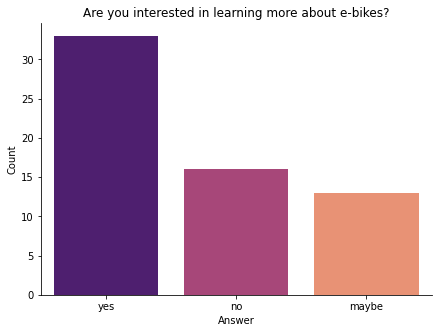

In [36]:
# Fix typo and category in answers
quant_df['interested'] = quant_df['interested'].str.strip()
quant_df['interested'] = quant_df['interested'].str.replace('may be', 'maybe')
quant_df['interested'] = quant_df['interested'].str.replace('already know', 'yes')
quant_df['interested'] = quant_df['interested'].str.replace('knows enough', 'yes')

# Count the number of occurrences of each unique value in the interested column
interested_count = quant_df['interested'].value_counts()

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.barplot(x=interested_count.index, y = interested_count.values, palette='magma')

# Set title and labels to the graph
plt.title('Are you interested in learning more about e-bikes?')
plt.xlabel('Answer')
plt.ylabel('Count')

## Part III: ...